In [119]:
import torch
import sys
sys.path.insert(0, '../scripts/')
from models import model_dict
from dataset import Galaxy10DECals
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from e2cnn import nn as e2cnn_nn
from cnn import ConvBlock as CNN_ConvBlock
import models
import cnn
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import warnings
from escnn import nn as escnn_nn

warnings.filterwarnings('ignore')
device = ('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToTensor()
    # transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

In [70]:
def add_poisson_noise(image: np.array, snr: float):
    """
    Adds Poisson noise to an image with a specified intensity.

    Args:
        image (numpy.ndarray): The input image is a 256 x 256 x 3 numpy array.
        snr (float): Normalized snr value (between 0 and 1)

    Returns:
        numpy.ndarray: The noisy image as a 256 x 256 x 3 numpy array.
    """
    
    if (snr > 1) or (snr < 0):
        raise ValueError('Unphysical SNR value. Specify 0 < snr < 1')
    
    signal_level = np.mean(image.numpy())
    noise_level = signal_level / snr  - signal_level
    noise = np.random.poisson(lam=noise_level, size=image.shape)
    noisy_image = np.clip(image + noise, 0, 255).to(torch.uint8)
    
    return noisy_image

In [21]:
data = Galaxy10DECals('/n/holystore01/LABS/iaifi_lab/Users/spandya/data/Galaxy10_DECals.h5') ## removed transform
test_loader = DataLoader(data, batch_size=1, shuffle=True)

In [107]:
images, labels = next(iter(test_loader))
images = images.permute(0,3,1,2).to(torch.float32)
images = F.interpolate(images, size=(255, 255), mode='bilinear', align_corners=True)

torch.Size([1, 3, 256, 256])


In [23]:
img = add_poisson_noise(images.squeeze().permute(1,2,0), 0.25)
img = img.unsqueeze(0).permute(0,3,2,1).to(torch.float32)
img = F.interpolate(img, size=(255, 255), mode='bilinear', align_corners=True)

In [76]:
print(images.shape, images.dtype)
print(img.shape, img.dtype)

torch.Size([1, 3, 256, 256]) torch.float32
torch.Size([1, 3, 256, 256]) torch.float32
torch.Size([1, 3, 255, 255])


In [28]:
model_str = 'D8'
model = model_dict[model_str]()
model.load_state_dict(torch.load(f'/n/holystore01/LABS/iaifi_lab/Users/spandya/new_icml/new_models/{model_str}.pt', map_location=device))

<All keys matched successfully>

In [25]:
model_str = 'CNN'
model_3 = model_dict[model_str]()
model_3.load_state_dict(torch.load(f'/n/holystore01/LABS/iaifi_lab/Users/spandya/new_icml/new_models/{model_str}.pt', map_location=device))

<All keys matched successfully>

In [129]:
def generate_rotations(image: torch.tensor):
    image_90 = torch.rot90(image, dims=(2,3))
    image_180 = torch.rot90(image_90, dims=(2,3))
    image_270 = torch.rot90(image_180, dims=(2,3))
    images = [image, image_90, image_180, image_270]
    return images

@torch.no_grad()
def visualize_feature_maps(model, image: torch.tensor, indices=None):
    model.eval()
    model_weights, conv_layers = [], []
    model_children = list(model.children())
    
    for i in range(len(model_children)):
        if type(model_children[i]) == models.ConvBlock:
            model_weights.append(model_children[i].conv.weights)
            conv_layers.append(model_children[i].conv.export())
            
        elif type(model_children[i]) == cnn.ConvBlock:
            model_weights.append(model_children[i].conv.weight)
            conv_layers.append(model_children[i].conv)
            
    model_weights, conv_layers = np.asarray(model_weights), np.asarray(conv_layers)
    
    assert len(conv_layers) == len(model_weights), "Number of conv layers and weights do not match"

    outputs = []
    names = []
    image_list = generate_rotations(image)
    image_list = [image.squeeze() for image in image_list]
    
    for images in image_list:
        for i, layer in enumerate(conv_layers):
            images = layer(images)
            if i == 0 or i == len(conv_layers) // 2 or i == len(conv_layers) - 1:
                outputs.append(images)
                names.append(str(layer))

    processed = []
    for feature_map in outputs:
        feature_map = feature_map.squeeze(0)
        gray_scale = torch.sum(feature_map,0)
        gray_scale = gray_scale / feature_map.shape[0]
        processed.append(gray_scale)
        
    images_to_plot = []

    num_rows = 4
    num_cols = int(len(processed) / num_rows)
    
    for i in range(num_rows):
        images_to_plot.append(image_list[i].permute(1,2,0).numpy().astype(np.uint8))
        images_to_plot.extend(processed[i*num_cols:(i+1)*num_cols])

    num_cols = num_cols + 1
    print(len(images_to_plot))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
    # fig.suptitle('ResNet18 (Noise Level: 75%)', y=0.925, size=10)
    
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            ax.imshow(images_to_plot[i])
            # j += 1
            ax.axis('off')
 
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    # fig.savefig('../../plots/resnet18_75_fm.png', bbox_inches='tight', dpi=300)
    plt.show()


16


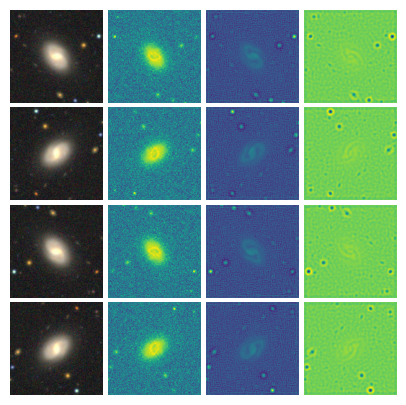

In [127]:
visualize_feature_maps(model, resized_images)

16


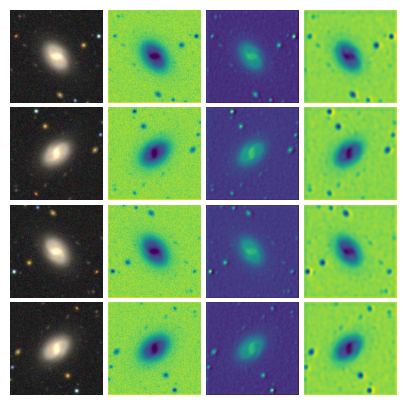

In [130]:
visualize_feature_maps(model_3, resized_images)